<a href="https://colab.research.google.com/github/Vtzachis/Projects/blob/main/Build_a_Neural_Network_from_Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [435]:
# Step 1: Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

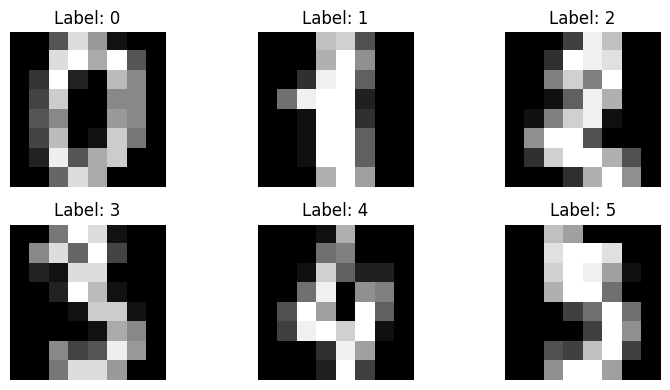

In [436]:
# Step 2: Load and explore the dataset
digits = load_digits()
X, y = digits.data, digits.target

# Visualize a few images
plt.figure(figsize=(8, 4))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(digits.images[i], cmap='gray')
    plt.title(f"Label: {digits.target[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [437]:
# Step 3: Preprocess the data
# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# One-hot encode the labels
encoder = OneHotEncoder(sparse_output=False)
y_onehot = encoder.fit_transform(y.reshape(-1, 1))

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_onehot, test_size=0.3, random_state=42)

In [438]:
# Step 4: Define activation functions and their derivatives
def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return (x > 0).astype(float)

def tanh(x):
    return np.tanh(x)

def tanh_derivative(x):
    return 1 - np.tanh(x) ** 2

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))  # for numerical stability
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

In [439]:
# Step 5: Initialize network parameters
np.random.seed(42)

input_size = X_train.shape[1]   # 64 features
hidden_size1 = 64
hidden_size2 = 32
output_size = y_train.shape[1] # 10 classes (digits 0-9)

# Xavier initialization
W1 = np.random.randn(input_size, hidden_size1) * np.sqrt(1 / input_size)
b1 = np.zeros((1, hidden_size1))

W2 = np.random.randn(hidden_size1, hidden_size2) * np.sqrt(1 / hidden_size1)
b2 = np.zeros((1, hidden_size2))

W3 = np.random.randn(hidden_size2, output_size) * np.sqrt(1 / hidden_size2)
b3 = np.zeros((1, output_size))

In [440]:
# Step 6: Define loss function (cross entropy)
def cross_entropy_loss(y_true, y_pred):
    eps = 1e-15
    y_pred = np.clip(y_pred, eps, 1 - eps)
    return -np.mean(np.sum(y_true * np.log(y_pred), axis=1))

In [441]:
# Adam optimizer beta stands for m
m = 0.9
v = 0.999
epsilon = 1e-8
t = 0

# Initialize moment estimates
m_W1, v_W1 = np.zeros_like(W1), np.zeros_like(W1)
m_b1, v_b1 = np.zeros_like(b1), np.zeros_like(b1)

m_W2, v_W2 = np.zeros_like(W2), np.zeros_like(W2)
m_b2, v_b2 = np.zeros_like(b2), np.zeros_like(b2)

m_W3, v_W3 = np.zeros_like(W3), np.zeros_like(W3)
m_b3, v_b3 = np.zeros_like(b3), np.zeros_like(b3)


In [442]:
# Step 7: Training the network
accuracy_history = []
loss_history = []
epochs = 200
learning_rate = 0.0001
batch_size = 64
for epoch in range(epochs):
  for batch in range(0, len(X_train), batch_size):
    X_batch = X_train[i:i+batch_size]
    y_batch = y_train[i:i+batch_size]
    t += 1
    # Forward pass
    z1 = X_train @ W1 + b1
    a1 = relu(z1)

    z2 = a1 @ W2 + b2
    a2 = tanh(z2)  # Different activation function in hidden layer 2

    z3 = a2 @ W3 + b3
    a3 = softmax(z3)  # Output layer uses softmax

    # Compute loss
    #L2 regu
    loss = cross_entropy_loss(y_train, a3)
    lambda_reg = 0.0001  # Regularization strength
    l2_term = lambda_reg * (np.sum(W1 ** 2) + np.sum(W2 ** 2) + np.sum(W3 ** 2))
    total_loss = loss + l2_term
   # Backpropagation
    delta3 = a3 - y_train
    dW3 = a2.T @ delta3
    db3 = np.sum(delta3, axis=0, keepdims=True)

    delta2 = (delta3 @ W3.T) * tanh_derivative(z2)
    dW2 = a1.T @ delta2
    db2 = np.sum(delta2, axis=0, keepdims=True)

    delta1 = (delta2 @ W2.T) * relu_derivative(z1)
    dW1 = X_train.T @ delta1
    db1 = np.sum(delta1, axis=0, keepdims=True)

    # Update weights and biases
    # Added Adam optimizer
    gW1 = dW1 + lambda_reg * W1  # add L2 reg
    m_W1 = m * m_W1 + (1 - m) * gW1
    v_W1 = v * v_W1 + (1 - v) * (gW1 ** 2)
    m_W1_corr = m_W1 / (1 - m ** t)
    v_W1_corr = v_W1 / (1 - v ** t)
    W1 -= learning_rate * m_W1_corr / (np.sqrt(v_W1_corr) + epsilon)

    m_b1 = m * m_b1 + (1 - m) * db1
    v_b1 = v * v_b1 + (1 - v) * (db1 ** 2)
    m_b1_corr = m_b1 / (1 - m ** t)
    v_b1_corr = v_b1 / (1 - v ** t)
    b1 -= learning_rate * m_b1_corr / (np.sqrt(v_b1_corr) + epsilon)

    gW2 = dW2 + lambda_reg * W2
    m_W2 = m * m_W2 + (1 - m) * gW2
    v_W2 = v * v_W2 + (1 - v) * (gW2 ** 2)
    m_W2_corr = m_W2 / (1 - m ** t)
    v_W2_corr = v_W2 / (1 - v ** t)
    W2 -= learning_rate * m_W2_corr / (np.sqrt(v_W2_corr) + epsilon)

    m_b2 = m * m_b2 + (1 - m) * db2
    v_b2 = v * v_b2 + (1 - v) * (db2 ** 2)
    m_b2_corr = m_b2 / (1 - m ** t)
    v_b2_corr = v_b2 / (1 - v ** t)
    b2 -= learning_rate * m_b2_corr / (np.sqrt(v_b2_corr) + epsilon)

    gW3 = dW3 + lambda_reg * W3
    m_W3 = m * m_W3 + (1 - m) * gW3
    v_W3 = v * v_W3 + (1 - v) * (gW3 ** 2)
    m_W3_corr = m_W3 / (1 - m ** t)
    v_W3_corr = v_W3 / (1 - v ** t)
    W3 -= learning_rate * m_W3_corr / (np.sqrt(v_W3_corr) + epsilon)

    m_b3 = m * m_b3 + (1 - m) * db3
    v_b3 = v * v_b3 + (1 - v) * (db3 ** 2)
    m_b3_corr = m_b3 / (1 - m ** t)
    v_b3_corr = v_b3 / (1 - v ** t)
    b3 -= learning_rate * m_b3_corr / (np.sqrt(v_b3_corr) + epsilon)



    # Print loss every 10 epochs
  if epoch % 10 == 0:
    print(f"Epoch {epoch} - Loss: {total_loss:.4f}")
  # Step 8: Evaluate on test set
  # Forward pass on test data
  # Indenting the accuracy test inside the loop for epochs so we can receive each accuracy respectivly

  z1_test = X_test @ W1 + b1
  a1_test = relu(z1_test)

  z2_test = a1_test @ W2 + b2
  a2_test = tanh(z2_test)

  z3_test = a2_test @ W3 + b3
  a3_test = softmax(z3_test)

  # Calculate accuracy

  predictions = np.argmax(a3_test, axis=1)
  labels = np.argmax(y_test, axis=1)
  accuracy = np.mean(predictions == labels)
  accuracy_history.append(accuracy)
  loss_history.append(total_loss)



  if epoch % 10 == 0:
      print(f"Epoch {epoch} — Accuracy: {accuracy:.4f}")




Epoch 0 - Loss: 2.2484
Epoch 0 — Accuracy: 0.1852
Epoch 10 - Loss: 1.3916
Epoch 10 — Accuracy: 0.7593
Epoch 20 - Loss: 0.8190
Epoch 20 — Accuracy: 0.8722
Epoch 30 - Loss: 0.5202
Epoch 30 — Accuracy: 0.9037
Epoch 40 - Loss: 0.3541
Epoch 40 — Accuracy: 0.9296
Epoch 50 - Loss: 0.2543
Epoch 50 — Accuracy: 0.9407
Epoch 60 - Loss: 0.1895
Epoch 60 — Accuracy: 0.9574
Epoch 70 - Loss: 0.1450
Epoch 70 — Accuracy: 0.9593
Epoch 80 - Loss: 0.1138
Epoch 80 — Accuracy: 0.9648
Epoch 90 - Loss: 0.0917
Epoch 90 — Accuracy: 0.9685
Epoch 100 - Loss: 0.0756
Epoch 100 — Accuracy: 0.9704
Epoch 110 - Loss: 0.0637
Epoch 110 — Accuracy: 0.9704
Epoch 120 - Loss: 0.0549
Epoch 120 — Accuracy: 0.9722
Epoch 130 - Loss: 0.0482
Epoch 130 — Accuracy: 0.9741
Epoch 140 - Loss: 0.0430
Epoch 140 — Accuracy: 0.9759
Epoch 150 - Loss: 0.0390
Epoch 150 — Accuracy: 0.9759
Epoch 160 - Loss: 0.0359
Epoch 160 — Accuracy: 0.9759
Epoch 170 - Loss: 0.0334
Epoch 170 — Accuracy: 0.9759
Epoch 180 - Loss: 0.0315
Epoch 180 — Accuracy: 0.9

In [443]:
# Step 8: Evaluate on test set
# Forward pass on test data

z1_test = X_test @ W1 + b1
a1_test = relu(z1_test)

z2_test = a1_test @ W2 + b2
a2_test = tanh(z2_test)

z3_test = a2_test @ W3 + b3
a3_test = softmax(z3_test)

# Calculate accuracy
predictions = np.argmax(a3_test, axis=1)
labels = np.argmax(y_test, axis=1)
accuracy = np.mean(predictions == labels)

print(f"Test accuracy: {accuracy:.4f}")




Test accuracy: 0.9759


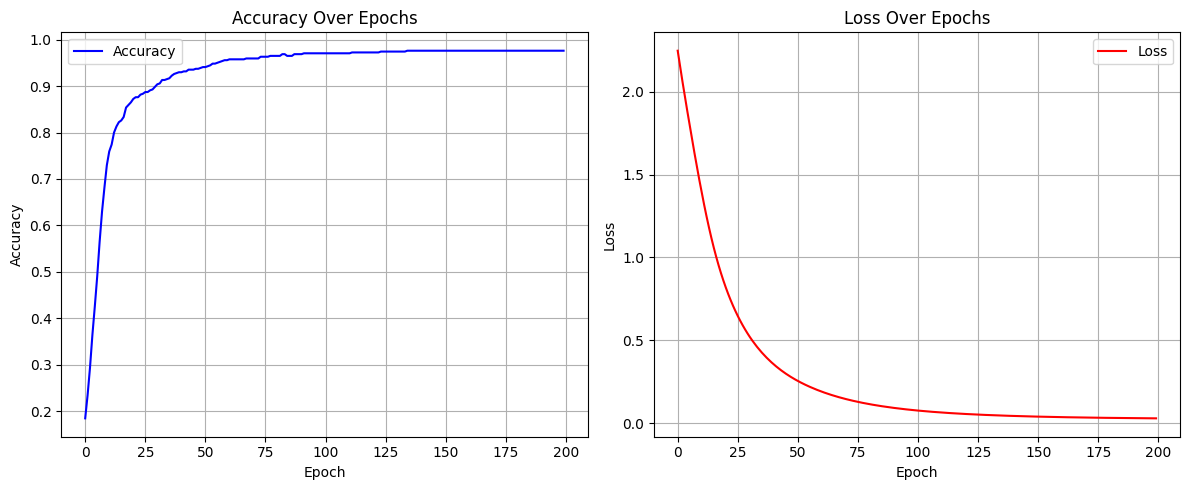

In [444]:
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(accuracy_history, label="Accuracy", color='blue')
plt.title("Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(loss_history, label="Loss", color='red')
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()
